Saving images (7).jfif to images (7).jfif

0: 320x640 1 person, 251.4ms
Speed: 3.6ms preprocess, 251.4ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 640)


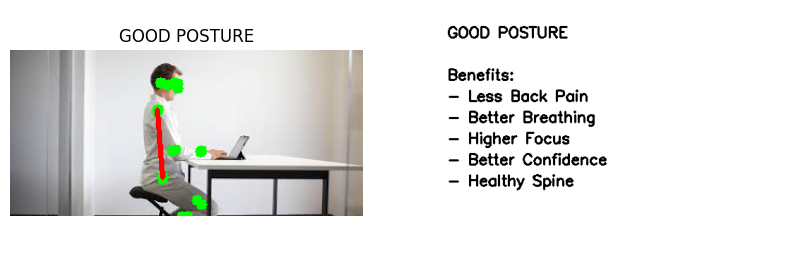

In [ ]:

!pip install ultralytics opencv-python matplotlib --quiet

import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from google.colab import files

model = YOLO("yolov8n-pose.pt")

uploaded = files.upload()
img_path = list(uploaded.keys())[0]

image = cv2.imread(img_path)
rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

results = model(rgb)
keypoints = results[0].keypoints.xy.cpu().numpy()

if len(keypoints) == 0:
    plt.imshow(rgb)
    plt.title("NO PERSON DETECTED")
    plt.axis("off")
    plt.show()

else:
    pts = keypoints[0]

    ls = pts[5]
    rs = pts[6]
    lh = pts[11]
    rh = pts[12]
    nose = pts[0]

    shoulder_center = (ls + rs) / 2
    hip_center = (lh + rh) / 2

    spine_vector = shoulder_center - hip_center
    spine_angle = np.degrees(np.arctan2(spine_vector[1], spine_vector[0]))
    spine_angle = abs(spine_angle)

    head_forward = nose[0] > shoulder_center[0] + 20

    bad = False
    if spine_angle < 70 or spine_angle > 110:
        bad = True
    if head_forward:
        bad = True

    posture = "BAD POSTURE" if bad else "GOOD POSTURE"

    for p in pts:
        cv2.circle(rgb, tuple(p.astype(int)), 5, (0,255,0), -1)

    cv2.line(rgb,
             tuple(hip_center.astype(int)),
             tuple(shoulder_center.astype(int)),
             (255,0,0), 3)

    info_img = np.ones((350, 500, 3), dtype=np.uint8) * 255

    if bad:
        lines = [
            "BAD POSTURE DETECTED",
            "",
            "Possible Risks:",
            "- Back Pain",
            "- Neck Strain",
            "- Headaches",
            "- Poor Breathing",
            "- Spine Problems",
            "",
            "Fix:",
            "Sit Straight | Screen at Eye Level"
        ]
    else:
        lines = [
            "GOOD POSTURE",
            "",
            "Benefits:",
            "- Less Back Pain",
            "- Better Breathing",
            "- Higher Focus",
            "- Better Confidence",
            "- Healthy Spine"
        ]

    y = 40
    for line in lines:
        cv2.putText(info_img, line, (20, y),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7,
                    (0,0,0), 2)
        y += 30

    plt.figure(figsize=(10,5))

    plt.subplot(1,2,1)
    plt.imshow(rgb)
    plt.title(posture)
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(info_img)
    plt.axis("off")

    plt.show()
